### Обучение обратным распостранением на основе датасета iris-ов

In [1]:
import sklearn.datasets
import sklearn.preprocessing
from matplotlib import pyplot as plt
import numpy as np
from math import ceil
from tqdm import tqdm
import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})

Загрузка датасета

In [2]:
from keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = (train_x / 255)
test_x = (test_x / 255)

train_x.resize(60000, 784)
test_x.resize(10000, 784)

encoder = sklearn.preprocessing.OneHotEncoder()
train_y = encoder.fit_transform(train_y[:, None]).toarray()
test_y = encoder.fit_transform(test_y[:, None]).toarray()

train_x.shape, train_y.shape

2024-11-25 15:30:11.798616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732537811.821975  161042 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732537811.828874  161042 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 15:30:11.851004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


((60000, 784), (60000, 10))

Реализуем необходимые функции активации нейроной для наших будущих слоёв

In [3]:
from typing import Callable, Tuple

type Nums = np.ndarray[np.number]
type NumsToNums = Callable[[Nums], Nums]
type NumsNumsToNums = Callable[[Nums, Nums], Nums]

def relu(x: Nums):
    return x * (x > 0)

def drelu(x: Nums):
    # производная функции relu
    return (x > 0)

def sigmoid(x: Nums):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x: Nums):
    s = sigmoid(x)
    return s * (1 - s)

def softmax(x: Nums):
    e_x = np.exp(x)
    sm = np.sum(e_x)
    return e_x / sm

def cross_entropy(z: Nums, y: Nums):
    # z - предсказанное, y - ожидаемое
    return -np.sum(y * np.log(z))

def error_function(pred: Nums, expected: Nums):
    # Получаем ошибку для последнего слоя нейросети
    return pred - expected

Реализуем универсальный класс для линейного слоя

In [4]:
class Layer:
    """
    Реализует линейный слой в многослойном перцептроне

    input_size: int - количество входных нейронов
    output_size: int - количество выходных нейронов
    weights: np.ndarray[np.number] - веса слоя
    bias: np.ndarray[np.number] - смещения
    
    self.activation_function: NumsToNums - функция активации слоя
    self.activation_function_derivation: NumsToNums - производная функции активации слоя
    """

    def __init__(
        self,
        input_size: int,
        output_size: int,
        activation_function: Tuple[
                NumsToNums,
                NumsToNums,
            ],
        weights_initialize_function: Callable[[Tuple[int, int]], Nums] = None
    ) -> None:
        """
        Args:
            input_size (int): размерность входных данных слоя
            output_size (int): размерность выходных данных слоя
            activation_function (NumsToNums, NumsToNums): кортеж из функции активации и её производной
            weights_initialize_function (Callable[[Tuple[int, int]], Nums]): функция инициализации весов,
            принимает кортеж shape 
        """
        self.input_size = input_size
        self.output_size = output_size
        if weights_initialize_function is None:
            weights_initialize_function = np.random.random
        
        self.weights = weights_initialize_function((input_size, output_size))
        self.bias = weights_initialize_function((1, output_size))
        self.activation_function = activation_function[0]
        self.activation_function_derivation = activation_function[1]
        
        # Значения x и t, фиксируемые при forward, нужны для вычисления ошибки
        self._xt = ()
        """
        Контейнеры для хранения вычисленных ошибок для весов и смещений
        Необходимы для того, чтобы можно было обучать батчами
        
        В батче, для каждого примера необходимо вызвать forward и backward.
        В конце батча, для модификации весов, необходимо вызвать update
        _errors_log будет очищен
        """
        self._errors_log = ([], [])

    def forward(self, x: Nums) -> Nums:
        # линейное преобразование
        t = x @ self.weights + self.bias
        # нелинейное преобразование
        h = self.activation_function(t)
        
        # Записываем значения, необходимые для вычисления ошибки
        self._xt = (x, t)
        return h

    def backward(self, error: Nums) -> Nums:
        """
        Обратное распространение ошибки
        Запоминает производные ошибки, но не изменяет параметры модели
        Для изменения нужно вызвать update
        """
        x, t = self._xt
        self._xt = ()
        
        de_dT = error * self.activation_function_derivation(t)
        de_dW = x.T @ de_dT
        de_dB = de_dT
        de_dX = de_dT @ self.weights.T
        self._errors_log[0].append(de_dW)
        self._errors_log[1].append(de_dB)
        return de_dX
    
    def update(self, learning_rate: float):
        """
        Модифицирует веса модели
        learning_rate: float, [0, 1] - на сколько сильно модель будет реагировать на ошибку
        """
        de_dWs, de_dBs = self._errors_log
        de_dW = np.sum(de_dWs, axis=0)
        de_dB = np.sum(de_dBs, axis=0)
        self.weights -= learning_rate * de_dW
        self.bias -= learning_rate * de_dB
        self._errors_log = ([], [])

    def __repr__(self) -> str:
        return f"<LinearLayer, {self.input_size}x{self.output_size}>"

Соответственно и общий класс для перцептрона с обучением по батчам

In [5]:
from typing import Any


class NN:
    """
    Полносвязная многослойная нейронная сеть
    """
    def __init__(
        self,
        layers: list[Layer],
        loss_function: NumsNumsToNums,
        error_function: NumsNumsToNums,
    ) -> None:
        self.layers = layers
        self.loss_function = loss_function  # Функция потерь
        self.error_function = error_function  # Функция для получения ошибки для последнего слоя
        
        # История значения loss_function, после train
        self.losses = []
        # Предсказания, полученные после train
        self.predicted = []
    
    def pop_loss(self, func: Callable[[Nums], Any]):
        loss = func(self.losses)
        self.losses.clear()
        return loss

    def forward(self, x: Nums) -> Nums:
        """
        Прямое распространение сети
        """
        current_x = x
        for layer in self.layers:
            current_x = layer.forward(current_x)

        return current_x

    def backward(self, error: Nums) -> Nums:
        """
        Обратное распространение сети, не меняет веса
        """
        current_error = error
        
        # Для последнего слоя ошибку получаем в error_function
        for layer in self.layers[::-1]:
            current_error = layer.backward(current_error)

        return current_error

    def update(self, learning_rate):
        """
        Модификация весов сети, все ошибки сохраняются в слои,
        стоит лишь вызвать данную функцию после однократного
        или серии применений (при batch) backward
        """
        for layer in self.layers[::-1]:
            layer.update(learning_rate)

    def train(self, xs: Nums, ys: Nums, learning_rate: float=0.001, batch_size: int=10):
        """
        Обучение сети в рамках одной эпохи
        """
        # Цикл по батчам, размера batch_size
        for batch_index in range(ceil(len(xs) / batch_size)):
            current_batch_slice = slice(
                batch_index * batch_size, (batch_index + 1) * batch_size
            )
            batch_xs = xs[current_batch_slice]
            batch_ys = ys[current_batch_slice]
            batch_losses = []  # Loss-ы одного батча

            for x, y in zip(batch_xs, batch_ys):
                x = x[None, ...]  # Для правильных размерностей (1, n), а не (n,)
                predict = self.forward(x)[0]
                error = self.error_function(predict, y)
                
                # Считаем ошибку
                self.backward(error)
                
                E = self.loss_function(predict, y)
                self.predicted.append(predict)
                batch_losses.append(E)

            # Обновляем веса
            self.update(learning_rate=learning_rate)
            
            # Собираем статистику
            batch_loss = np.sum(batch_losses)
            batch_losses.clear()
            self.losses.append(batch_loss)

Создадим экземпляр нашего перцептрона и обучим его

In [ ]:
network = NN(
    [
        Layer(784, 128, (relu, drelu), weights_initialize_function=lambda shape: np.random.random(shape) * 0.01),
        Layer(128, 10, (softmax, lambda x: x), weights_initialize_function=lambda shape: np.random.random(shape) * 0.01),  # x -> softmax(x)  # x -> x - транзитом, не считаем производную
    ],
    loss_function=cross_entropy,
    error_function=error_function,
)

def train(network: NN, x: Nums, y: Nums, num_epoches: int, learning_rate: float, batch_size: int):
    bar = tqdm(range(1, num_epoches + 1), total=num_epoches)
    xy_indices = np.arange(len(x))
    loss_history = []
    for epoch in bar:
        network.predicted.clear()
        # В каждой эпохе изменим порядок обучающего датасета
        np.random.shuffle(xy_indices)
        
        indices = np.random.choice(len(xy_indices), size=10000, replace=False)
        
        epoch_x = x[indices]
        epoch_y = y[indices]
        network.train(epoch_x, epoch_y, learning_rate=learning_rate, batch_size=batch_size)
        
        loss = network.pop_loss(np.min)
        loss_history.append(loss)
        y_pred_classes = np.argmax(network.predicted, axis=1)
        y_true_classes = np.argmax(epoch_y, axis=1)

        acc = sklearn.metrics.accuracy_score(y_true_classes, y_pred_classes)
        f1 = sklearn.metrics.f1_score(y_true_classes, y_pred_classes, average='weighted')
        
        bar.set_description(f"epoch: {epoch}, loss: {loss:.10f}, acc: {acc:.3f}, f1: {f1:.3f}")
        # print(f"epoch: {epoch}, loss: {loss:.10f}, acc: {acc:.3f}, f1: {f1:.3f}")
        network.losses.clear()
    return loss_history

loss_history = train(network, train_x, train_y, 10, 0.001, 1)

epoch: 5, loss: 0.0000000234, acc: 0.932, f1: 0.932:  50%|█████     | 5/10 [00:21<00:21,  4.31s/it]

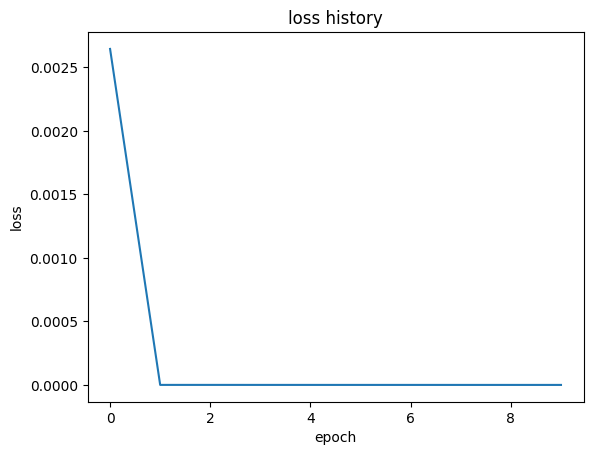

In [ ]:
fig, ax = plt.subplots()

ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("loss history")
plt.show()

Посмотрим на результат обучения на валидационной выборке

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       980
           2       0.98      0.98      0.98      1135
           3       0.97      0.93      0.95      1032
           4       0.97      0.93      0.95      1010
           5       0.95      0.96      0.96       982
           6       0.93      0.96      0.94       892
           7       0.96      0.96      0.96       958
           8       0.94      0.97      0.96      1028
           9       0.91      0.96      0.94       974
          10       0.98      0.92      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



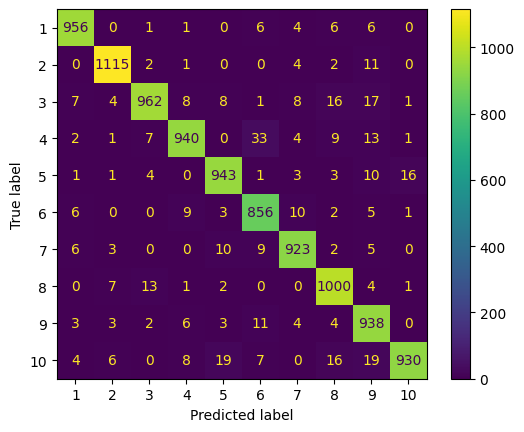

In [ ]:
y_pred = network.forward(test_x)

y_pred_classes = [x + 1 for x in np.argmax(y_pred, axis=1)]
y_true_classes = [x + 1 for x in np.argmax(test_y, axis=1)]

print(sklearn.metrics.classification_report(y_true_classes, y_pred_classes))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)

Ура!